<a href="https://colab.research.google.com/github/asyali-mh/American_Sign_Language_Classification/blob/main/asl_classification_cnn_model_ver1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Import packages and set numpy random seed
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import pathlib
from keras.utils import image_dataset_from_directory
from keras.models import Sequential
from keras.layers import Rescaling, CenterCrop, Conv2D, MaxPool2D, BatchNormalization, Flatten, Dense

In [ ]:
# Confirm that data is available at the input directory..
!ls -all /kaggle/input/

total 8
drwxr-xr-x 3 root   root    4096 May 28 18:16 .
drwxr-xr-x 5 root   root    4096 May 28 18:16 ..
drwxr-xr-x 4 nobody nogroup    0 Sep 19  2022 asl-alphabet


### Set-up Training and Validation Image Data Generators using "image_dataset_from_directory" Utility

In [ ]:
# Define path pointing to the folder containing image files..
image_dir = '/kaggle/input/asl-alphabet/asl_alphabet_train/asl_alphabet_train/'
batch_size = 128 # Define batch size..
image_size = (200,200) # Define image size, number of channels is 3 (i.e. images are in 'rgb' format)
# Define the training data generator..
train_ds = image_dataset_from_directory(image_dir,validation_split=.2,subset="training",
                                        shuffle=True,seed=42,image_size=image_size,batch_size=batch_size)
# Define the validation data generator..
val_ds = image_dataset_from_directory(image_dir,validation_split=.2,subset="validation",
                                      shuffle=True,seed=42,image_size=image_size,batch_size=batch_size)
# Get class names and class count..
class_names = val_ds.class_names; n_classes = len(class_names)
print('Class names:',end=' '); print(*class_names, sep=', ')

Found 87000 files belonging to 29 classes.
Using 69600 files for training.
Found 87000 files belonging to 29 classes.
Using 17400 files for validation.
Class names: A, B, C, D, E, F, G, H, I, J, K, L, M, N, O, P, Q, R, S, T, U, V, W, X, Y, Z, del, nothing, space


In [ ]:
# Check class distribution of batches of samples to ensure stratification is achieved..
def check_class_counts(data_set,num_iters=3*n_classes,case_str='training'):
    data_iter = iter(data_set)
    cnt_mtrx = np.zeros((num_iters,n_classes))
    range_idx = range(n_classes)
    for k in range(num_iters):
        _, labels = next(data_iter)
        class_counts = [sum(labels.numpy()==i) for i in range_idx]
        cnt_mtrx[k,:] = class_counts
    print(f'\nResults for {case_str} data\n{"-"*27}')
    print(f'Number of samples drawn: From count matrix = {cnt_mtrx.sum():.0f}, From formula = {batch_size*num_iters = }')
    print(f'Class distribution of samples: {cnt_mtrx.sum(0).astype(int)}')
    print(f'Mean of class counts: {cnt_mtrx.sum(0).mean():.0f} (Should be equal to {batch_size*num_iters/n_classes = :.0f})')
check_class_counts(train_ds)
check_class_counts(val_ds,case_str='validation')


Results for training data
---------------------------
Number of samples drawn: From count matrix = 11136, From formula = batch_size*num_iters = 11136
Class distribution of samples: [376 368 386 364 392 373 381 362 383 395 383 375 393 413 400 359 367 400
 377 408 379 437 417 420 362 358 394 360 354]
Mean of class counts: 384 (Should be equal to batch_size*num_iters/n_classes = 384)

Results for validation data
---------------------------
Number of samples drawn: From count matrix = 11136, From formula = batch_size*num_iters = 11136
Class distribution of samples: [378 412 379 425 356 435 380 392 378 397 344 364 379 355 381 376 420 333
 397 404 395 356 367 360 415 394 372 393 399]
Mean of class counts: 384 (Should be equal to batch_size*num_iters/n_classes = 384)


### Visualize the Training Data
Let's visualize several images from the training and validation data, along with their corresponding class labels.

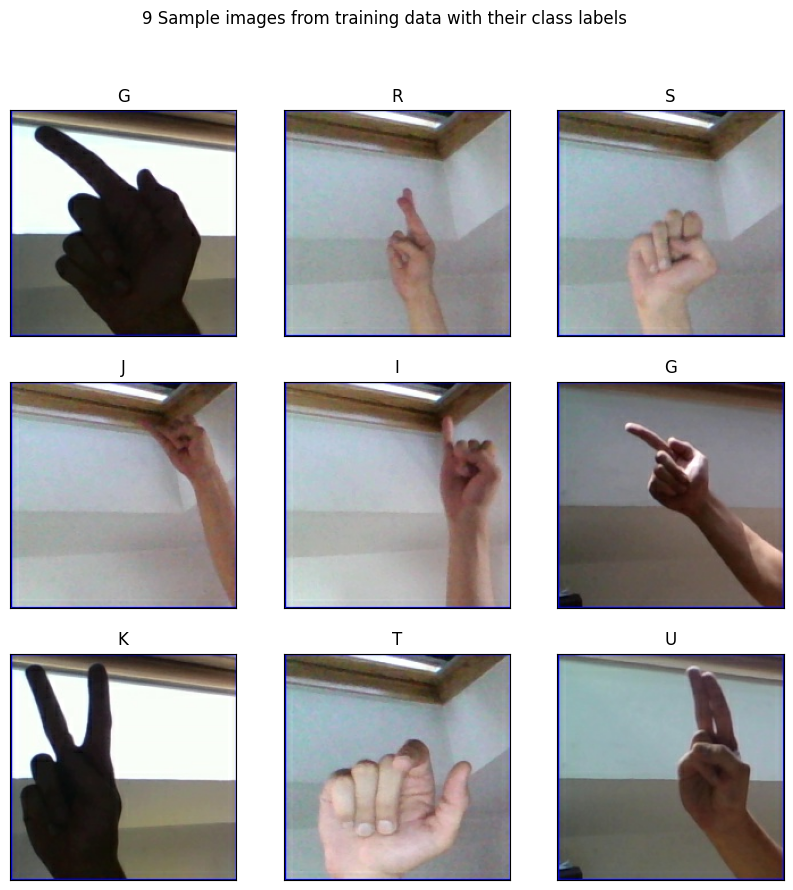

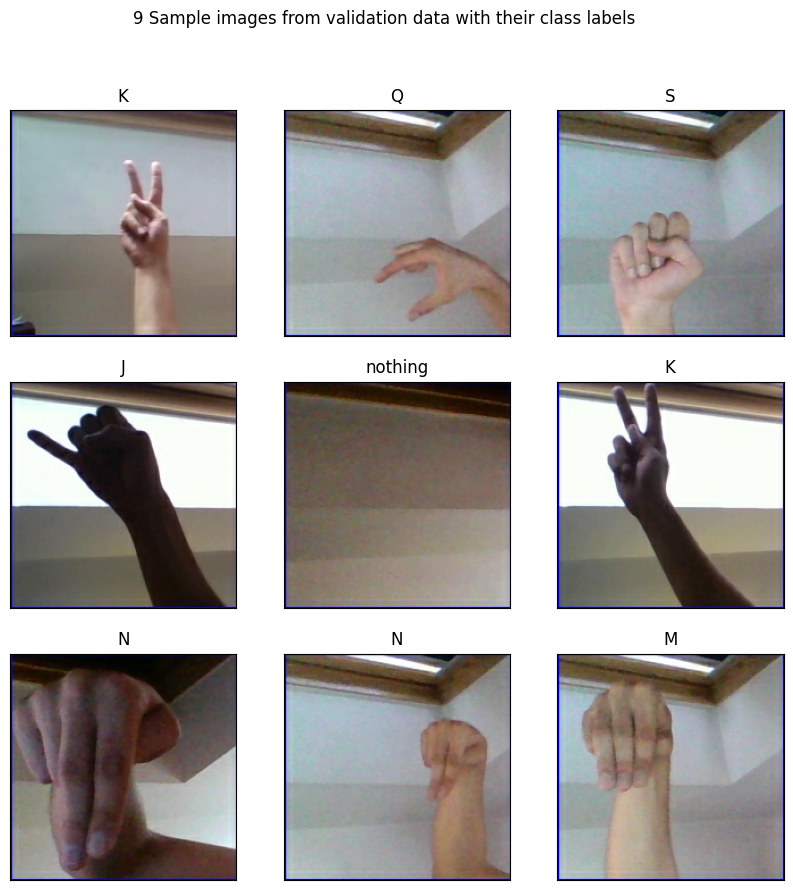

In [ ]:
# Display sample images from training and validation data generators..
def display_sample_images(data_set,case_str='training'):
    fig = plt.figure(figsize=(10,10))
    for images, labels in data_set.take(1):
      for i in range(9):
        ax = fig.add_subplot(3,3,i+1,xticks=[],yticks=[])
        ax.imshow(images[i].numpy().astype("uint8"))
        ax.set_title(class_names[labels[i]])
    plt.suptitle(f'9 Sample images from {case_str} data with their class labels')
display_sample_images(train_ds)
display_sample_images(val_ds,'validation')

### Set-up the TPU

In [ ]:
try:
    # Locate TPUs on the network
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()
    tpu_strategy = tf.distribute.TPUStrategy(tpu)
except ValueError: # If TPU is not available
    tpu_strategy = tf.distribute.get_strategy() # default strategy that works on CPU and single GPU
print("Number of accelerators:", tpu_strategy.num_replicas_in_sync)    

INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.
INFO:tensorflow:Initializing the TPU system: local
INFO:tensorflow:Finished initializing TPU system.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:0, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:1, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:2, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:3, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:4, TPU

### Define and Compile the Convolutional Neural Network Model
<p>Now it's time to define a convolutional neural network to classify the data (i.e. ASL images) .</p>
<p>This network accepts an image of an American Sign Language letter image as input.  The output layer returns the network's predicted probabilities that the image belongs in each category.</p>

In [ ]:
def get_model(ker_reg_fn=None):
    # Try 'l1','l2', and 'l1_l2' as kernel regularizer functions..
    model = Sequential()
    # Preprocessing (crop and rescale)
    model.add(CenterCrop(196,196,input_shape=(200,200,3)))
    model.add(Rescaling(1./255))
    # First convolutional layer accepts image input
    model.add(Conv2D(64,3,kernel_regularizer=ker_reg_fn,activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPool2D())
    # Add another convolutional layer
    model.add(Conv2D(32,3,kernel_regularizer=ker_reg_fn,activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPool2D())
    # Add another convolutional layer
    model.add(Conv2D(16,3,kernel_regularizer=ker_reg_fn,activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPool2D())
    # Flatten and feed to a dense layer
    model.add(Flatten())
    model.add(Dense(n_classes//2,kernel_regularizer=ker_reg_fn,activation='relu'))
    model.add(BatchNormalization())
    # Feed to a dense output layer with softmax activations..
    model.add(Dense(n_classes,kernel_regularizer=ker_reg_fn,activation='softmax'))
    # Compile the model
    model.compile(optimizer='adam',loss='SparseCategoricalCrossentropy',metrics=['accuracy'])
    return model

### Train the Convolutional Neural Network Model
Try different models (i.e. with different regularization strategies) and assess their performance.

In [ ]:
# Helper function to defne model on TPU with the specified regularization strategy
def get_model_on_TPU(ker_reg_fn,summary_flag=False):
    # Instantiate the CNN model in the TPU strategy scope to create it on the TPU
    with tpu_strategy.scope():
        # Define training and validation data iterators using "flow_from_directory" method of ImageDataGenerator  
        model = get_model(ker_reg_fn)
        # Summarize the model if the flag is set..
        if summary_flag: model.summary()
    return model

In [ ]:
# Helper function to display training results..
def plot_results(history,L,case_str):
    range_x = range(1,L+1)
    # Plot time (i.e. epoch) evolution of both training and validation loss and accuracy..
    fig = plt.figure(figsize=(10,5))
    ax = fig.add_subplot(1,2,1)
    ax.plot(range_x,history['loss']); ax.plot(history['val_loss'])
    ax.set_title('Loss'); ax.legend(['Training','Validation'])
    ax = fig.add_subplot(1,2,2)
    ax.plot(range_x,history['accuracy']); ax.plot(history['val_accuracy'])
    ax.set_title('Accuracy'); ax.legend(['Training','Validation'])
    plt.suptitle(f'Kernel Regularizer: {case_str}'); plt.show()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 center_crop (CenterCrop)    (None, 196, 196, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 196, 196, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 194, 194, 64)      1792      
                                                                 
 batch_normalization (BatchN  (None, 194, 194, 64)     256       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 97, 97, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 95, 95, 32)        1

2023-05-28 19:24:50.220587: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-05-28 19:24:50.376031: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


544/544 [==============================] - ETA: 0s - loss: 1.7243 - accuracy: 0.5615

2023-05-28 19:25:29.183369: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-05-28 19:25:29.295529: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


544/544 [==============================] - 53s 80ms/step - loss: 1.7243 - accuracy: 0.5615 - val_loss: 2.1652 - val_accuracy: 0.3224
Epoch 2/50
544/544 [==============================] - 30s 55ms/step - loss: 0.4639 - accuracy: 0.8927 - val_loss: 1.0427 - val_accuracy: 0.6674
Epoch 3/50
544/544 [==============================] - 30s 55ms/step - loss: 0.2152 - accuracy: 0.9478 - val_loss: 0.1915 - val_accuracy: 0.9475
Epoch 4/50
544/544 [==============================] - 30s 55ms/step - loss: 0.1293 - accuracy: 0.9674 - val_loss: 0.2492 - val_accuracy: 0.9187
Epoch 5/50
544/544 [==============================] - 30s 55ms/step - loss: 0.0940 - accuracy: 0.9749 - val_loss: 0.7002 - val_accuracy: 0.7903
Epoch 6/50
544/544 [==============================] - 30s 55ms/step - loss: 0.0769 - accuracy: 0.9786 - val_loss: 0.0853 - val_accuracy: 0.9749
Epoch 7/50
544/544 [==============================] - 30s 56ms/step - loss: 0.0601 - accuracy: 0.9831 - val_loss: 0.0851 - val_accuracy: 0.9720
Epo

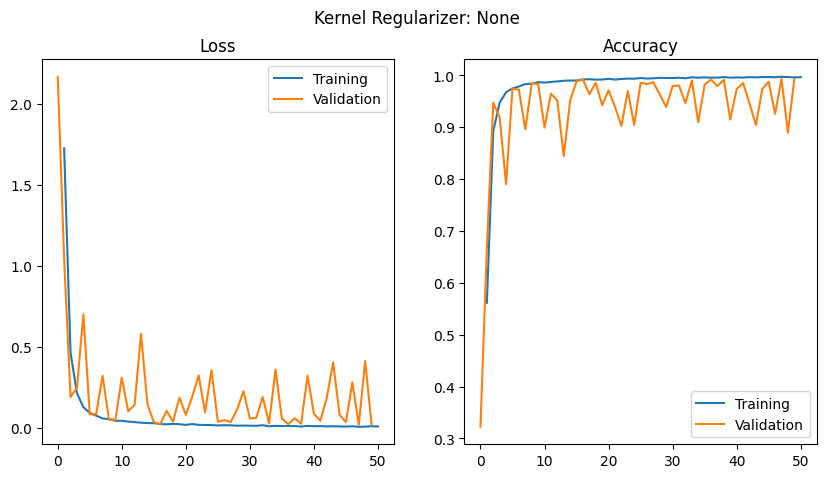


Results for kernel regularizer: l1
-------------------------------------
Epoch 1/50


2023-05-28 19:50:41.869195: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-05-28 19:50:42.027102: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


544/544 [==============================] - ETA: 0s - loss: 5.5511 - accuracy: 0.4423

2023-05-28 19:51:21.078518: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-05-28 19:51:21.200535: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


544/544 [==============================] - 53s 79ms/step - loss: 5.5511 - accuracy: 0.4423 - val_loss: 6.0465 - val_accuracy: 0.0348
Epoch 2/50
544/544 [==============================] - 30s 55ms/step - loss: 2.7361 - accuracy: 0.7079 - val_loss: 2.6292 - val_accuracy: 0.7033
Epoch 3/50
544/544 [==============================] - 30s 55ms/step - loss: 2.4414 - accuracy: 0.7642 - val_loss: 2.3017 - val_accuracy: 0.7852
Epoch 4/50
544/544 [==============================] - 30s 56ms/step - loss: 2.3317 - accuracy: 0.7842 - val_loss: 2.2368 - val_accuracy: 0.7799
Epoch 5/50
544/544 [==============================] - 30s 55ms/step - loss: 2.2539 - accuracy: 0.7956 - val_loss: 2.2743 - val_accuracy: 0.7891
Epoch 6/50
544/544 [==============================] - 30s 55ms/step - loss: 2.1940 - accuracy: 0.8046 - val_loss: 2.0557 - val_accuracy: 0.8399
Epoch 7/50
544/544 [==============================] - 30s 55ms/step - loss: 2.1602 - accuracy: 0.8069 - val_loss: 2.1002 - val_accuracy: 0.8125
Epo

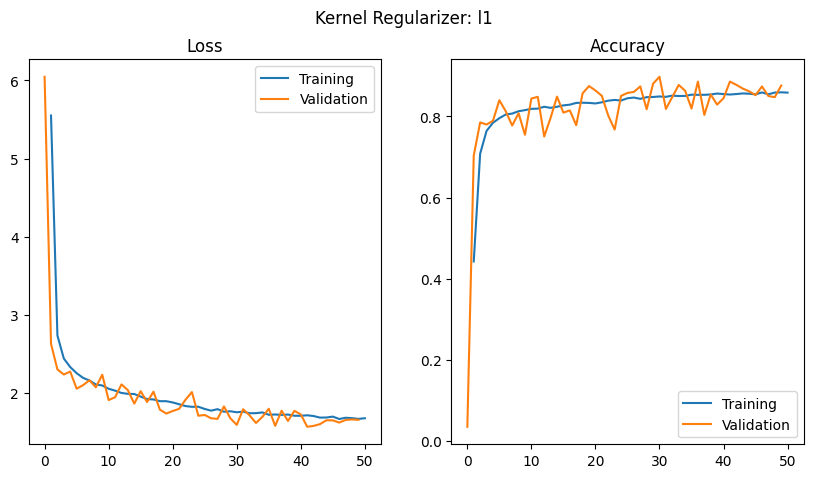


Results for kernel regularizer: l2
-------------------------------------
Epoch 1/50


2023-05-28 20:16:39.903220: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-05-28 20:16:40.070578: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


544/544 [==============================] - ETA: 0s - loss: 2.4430 - accuracy: 0.5856

2023-05-28 20:17:18.996070: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-05-28 20:17:19.139436: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


544/544 [==============================] - 53s 79ms/step - loss: 2.4430 - accuracy: 0.5856 - val_loss: 3.6051 - val_accuracy: 0.1577
Epoch 2/50
544/544 [==============================] - 30s 55ms/step - loss: 1.1556 - accuracy: 0.9064 - val_loss: 1.6525 - val_accuracy: 0.7172
Epoch 3/50
544/544 [==============================] - 30s 55ms/step - loss: 0.8705 - accuracy: 0.9465 - val_loss: 0.8906 - val_accuracy: 0.9220
Epoch 4/50
544/544 [==============================] - 30s 55ms/step - loss: 0.7336 - accuracy: 0.9579 - val_loss: 0.8585 - val_accuracy: 0.8896
Epoch 5/50
544/544 [==============================] - 30s 55ms/step - loss: 0.6530 - accuracy: 0.9626 - val_loss: 1.0087 - val_accuracy: 0.8095
Epoch 6/50
544/544 [==============================] - 30s 55ms/step - loss: 0.5923 - accuracy: 0.9666 - val_loss: 0.6687 - val_accuracy: 0.9401
Epoch 7/50
544/544 [==============================] - 30s 55ms/step - loss: 0.5451 - accuracy: 0.9695 - val_loss: 0.6725 - val_accuracy: 0.9245
Epo

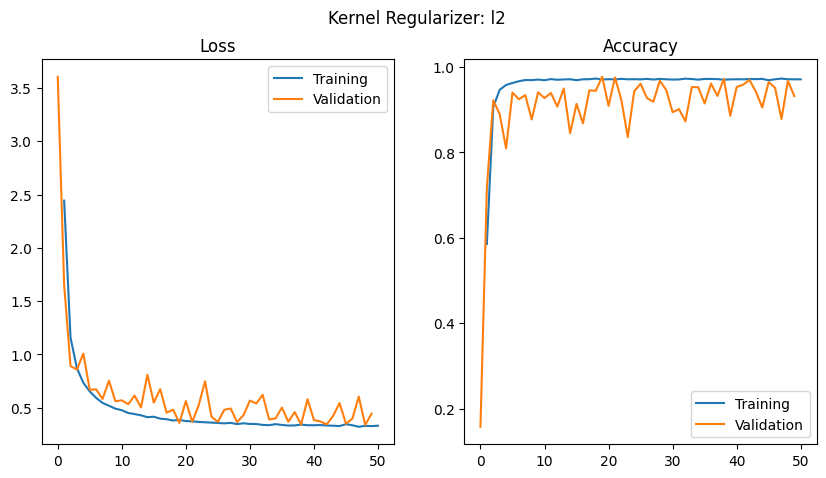


Results for kernel regularizer: l1_l2
-------------------------------------
Epoch 1/50


2023-05-28 20:42:45.413836: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-05-28 20:42:45.583910: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


544/544 [==============================] - ETA: 0s - loss: 5.5760 - accuracy: 0.4292

2023-05-28 20:43:24.233218: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-05-28 20:43:24.350989: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


544/544 [==============================] - 53s 79ms/step - loss: 5.5760 - accuracy: 0.4292 - val_loss: 5.5939 - val_accuracy: 0.0348
Epoch 2/50
544/544 [==============================] - 30s 55ms/step - loss: 2.8268 - accuracy: 0.7222 - val_loss: 2.8756 - val_accuracy: 0.6605
Epoch 3/50
544/544 [==============================] - 31s 56ms/step - loss: 2.6000 - accuracy: 0.7679 - val_loss: 2.5706 - val_accuracy: 0.7345
Epoch 4/50
544/544 [==============================] - 30s 56ms/step - loss: 2.4713 - accuracy: 0.7844 - val_loss: 2.3442 - val_accuracy: 0.7960
Epoch 5/50
544/544 [==============================] - 30s 56ms/step - loss: 2.3798 - accuracy: 0.7951 - val_loss: 2.3546 - val_accuracy: 0.7828
Epoch 6/50
544/544 [==============================] - 30s 56ms/step - loss: 2.2931 - accuracy: 0.8023 - val_loss: 2.5214 - val_accuracy: 0.7094
Epoch 7/50
544/544 [==============================] - 30s 56ms/step - loss: 2.2534 - accuracy: 0.8052 - val_loss: 2.1672 - val_accuracy: 0.8036
Epo

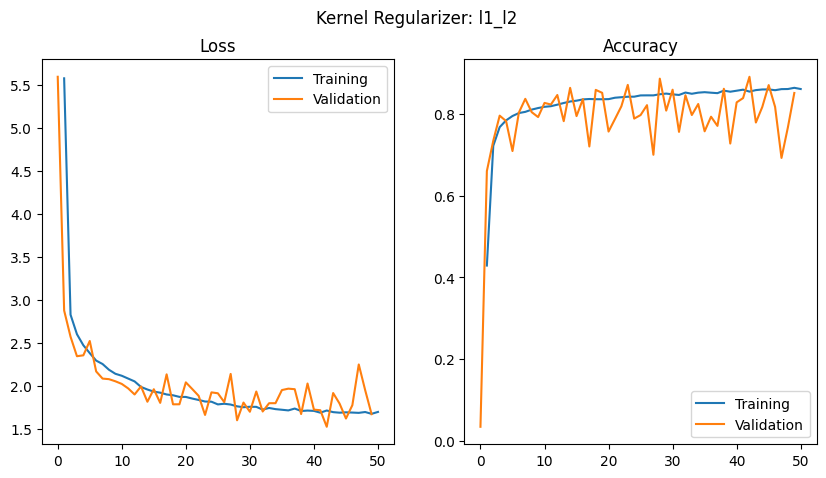

In [ ]:
# Set number of epochs and start training..
n_epochs = 50
for ker_reg_fn in [None,'l1','l2','l1_l2']: # Loop over different models..
    if ker_reg_fn is None:
        model = get_model_on_TPU(ker_reg_fn,True) # Display summary for the 1st case..
    else:
        model = get_model_on_TPU(ker_reg_fn)
    print(f'\nResults for kernel regularizer: {ker_reg_fn}\n{"-"*37}')
    history = model.fit(train_ds, validation_data = val_ds, epochs = n_epochs)
    plot_results(history.history,n_epochs,ker_reg_fn)